In [1]:
# TODO:
# correlation of features output for two networks. Or even FC training from from to other with L1/L2 norm?
# start develop liveconv
# don't forger penalise for operation, not (just) weight. Add stats on operations
# why features' weights small but not zero? should I try depth-separable conv?
# manual livenet for cifar10, and then think on auto?

%load_ext autoreload
%autoreload 2
import torch
import torch.utils
import torch.utils.data
import torchsummary
import numpy as np
import gc
from livenet.utils import set_seed
import onnx
import livenet
from livenet.v2.context2 import Context2
device = "cuda"
#device = "cpu"
#torch.set_default_device(device)
torch.use_deterministic_algorithms(False)
from ai_libs.simple_log import LOG


In [2]:
batch_size = 256
from livenet.datasets import TransformDataset
test_x, test_y = livenet.datasets.get_cifar10_test()
test = torch.utils.data.TensorDataset(test_x, test_y)
test_aug = TransformDataset(test, livenet.datasets.cifar10_test_transform)
test_loader = torch.utils.data.DataLoader(test_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=4, pin_memory=True)

train_x, train_y = livenet.datasets.get_cifar10_train()
train = torch.utils.data.TensorDataset(train_x, train_y)
train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)
train_loader = torch.utils.data.DataLoader(train_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=16, pin_memory=True, prefetch_factor=2)



57.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [3]:

train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)


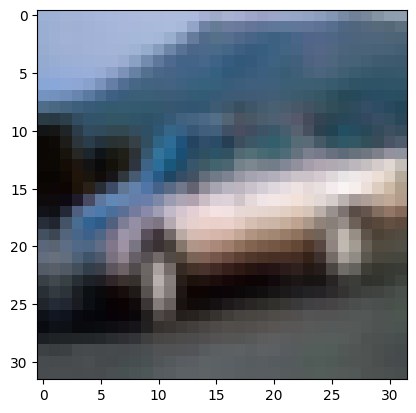

In [4]:
img = train_aug[4][0].numpy()
img = img.transpose(1, 2, 0)
from matplotlib import pyplot as plt
#img = livenet.datasets._elastic_transform(img, (-4, 0))
img = (img * 128 + 127).astype(np.uint8)

#plt.imsave("/home/spometun/img.png", img)
plt.imshow( img )

In [5]:
# from cifar_arch import EffNet, ResNet9, ResNet9Small
from livenet.v2.cifar_arch_smart import ResNet9SmallSmart

set_seed(2)

# network = EffNet(device)
# network = ResNet9Small(3, 10, device)
context = Context2(regularization_l1=0.001*1e-6)
network = ResNet9SmallSmart(context, 3, 10, device)
torchsummary.summary(network, (3, 32, 32), device=device)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       SmartConv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
             ReLU6-3           [-1, 16, 32, 32]               0
       SmartConv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
       SmartConv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
            ReLU6-10           [-1, 32, 16, 16]               0
      SmartConv2d-11           [-1, 32, 16, 16]           9,248
      BatchNorm2d-12           [-1, 32, 16, 16]              64
            ReLU6-13           [-1, 32, 16, 16]               0
      SmartConv2d-14           [-1, 32,

In [6]:
dummy_input = torch.zeros(size=(1, 3, 32, 32), device=device)
torch.onnx.export(network, dummy_input, "/home/spometun/temp/resnet9small.onnx")

RuntimeError: Detected that you are using FX to torch.jit.trace a dynamo-optimized function. This is not supported at the moment.

In [7]:
np.set_printoptions(precision=3, suppress=True)
ax_in = (0, 2, 3)
ax_out = (1, 2, 3)
ax = ax_out
vals = list(network.parameters())[32].data.cpu().numpy()
vals_ref = list(network.parameters())[32].data
out_max = np.max(vals, axis=ax)
out_min = np.min(vals, axis=ax)
sign = -out_min > out_max
out = np.max(np.abs(vals), axis=ax)
#out *= 1 - sign * 2
LOG(f"{np.min(vals):.2f} {np.max(vals):.2f}")
print(np.sum(np.abs(vals) < 0.01), np.sum(np.abs(vals) > 0.0))
#vals_ref[np.abs(vals) < 0.05] = 0.0
out

Iˈ0.000 -2.20 2.44 
0 32


array([[0.328],
       [2.198],
       [1.562],
       [1.313],
       [1.115],
       [1.513],
       [2.438],
       [0.728],
       [0.172],
       [2.01 ],
       [0.105],
       [1.246],
       [1.509],
       [0.133],
       [0.887],
       [0.139],
       [1.583],
       [2.142],
       [2.178],
       [0.776],
       [0.075],
       [2.079],
       [0.808],
       [1.608],
       [1.654],
       [2.066],
       [0.074],
       [1.721],
       [1.738],
       [0.084],
       [0.825],
       [1.399]], dtype=float32)

In [10]:
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
trainer = livenet.net_trainer.NetTrainer(network, train_loader, criterion, optimizer)
optimizer.learning_rate = 0.01



Adam


In [11]:
network.train()
network.context.regularization_l1 = 1*1e-6
trainer.step(5000)


Iˈ0.000 195 2.950+0.000reg params=38 lr=0.01000 livenet/net_trainer.py:128


KeyError: 'batch_size'

In [12]:
gc.collect()
torch.cuda.empty_cache()

def _infer_epoch(network, loader):
    preds = []
    ys = []
    with torch.no_grad():
        for x, y in iter(loader):
            x = x.to(network.device)
            pred = network(x)
            pred = pred.cpu()
            preds.append(pred)
            ys.append(y.cpu())
    pred = torch.concatenate(preds)
    y = torch.concatenate(ys)
    return pred, y


network.train()
#train_pred, train_labels = _infer_epoch(network, train_loader)
test_pred, test_labels = _infer_epoch(network, test_loader)

network.eval()
test_pred, test_labels = _infer_epoch(network, test_loader)
train_pred, train_labels = _infer_epoch(network, train_loader)

def calc_accuracy(predictions, labels):
    _, predicted = torch.max(predictions.data, 1)
    labels = labels.numpy()
    labels = np.squeeze(labels, 1)
    predicted = predicted.numpy()
    correct = np.sum(predicted == labels)
    total = len(labels)
    accuracy = correct / total
    return accuracy


# test_y_tensor = torch.tensor(test_y, device="cpu")
# train_y_tensor = torch.tensor(train_y, device="cpu")
test_loss = trainer.criterion(test_pred, test_labels).item()
train_loss = trainer.criterion(train_pred, train_labels).item()
LOG(f"loss: train: {train_loss:.3f} test: {test_loss:.3f}")

test_accuracy = calc_accuracy(test_pred, test_labels)
train_accuracy = calc_accuracy(train_pred, train_labels)
LOG(f"accuracy, train: {100 * train_accuracy:.1f}% test: {100 * test_accuracy:.1f}%")

/home/spometun/miniconda3/envs/home/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
W0525 20:40:38.197000 90479 site-packages/torch/_inductor/utils.py:1250] [0/5] Not enough SMs to use max_autotune_gemm mode
W0525 20:41:13.684000 90479 site-packages/torch/_dynamo/convert_frame.py:964] [0/8] torch._dynamo hit config.recompile_limit (8)
W0525 20:41:13.684000 90479 site-packages/torch/_dynamo/convert_frame.py:964] [0/8]    function: 'forward' (/home/spometun/projects/home_project/livenet/v2/smart_conv.py:42)
W0525 20:41:13.684000 90479 site-packages/torch/_dynamo/convert_frame.py:964] [0/8]    last reason: 0/7: tensor 'self.stats['ops_amount_sum']' size mismatch at index 0. expected 128, actual 1
W0525 20:41:13.684000 90479 site-packages/torch/_dynamo/convert_frame.py:964]

Iˈ0.000 loss: train: 1.037 test: 0.644 
Iˈ0.001 accuracy, train: 75.2% test: 84.5% 


In [ ]:
network.to("cpu")

In [ ]:
param = list(network.named_parameters())
param0 = list(network.parameters())


In [ ]:
w = param[12][1].detach().cpu().numpy()
m = np.max(np.abs(w), axis=(1, 2, 3))
f"{int(100 * np.sum(m > 0.01) / len(m))}%"
np.sum(m > 0.01)

In [ ]:
outs = dict()
for i in range(11):
    ind = i * 4
    if ind >= 36:
        ind = 32 + (i - 8)
    w = param[ind][1].detach().cpu().numpy()
    w_name = param[ind][0]
    m_out = np.max(np.abs(w), axis=(1, 2, 3))
    outs[ind] = m_out > 0.01
    m_in = np.max(np.abs(w), axis=(0, 2, 3))
    n_out = np.sum(m_out > 0.01)
    n_in = np.sum(m_in > 0.01)
    s = f"{w_name} {ind}, {w.shape} {int(100 * np.sum(m_out > 0.01) / len(m_out))}%, {n_in}->{n_out}"
    print(s)
for ind in [12, 28]:
    ind2 = 32 if ind == 12 else 33
    n_inter = np.sum(outs[ind] * outs[ind2])
    print(f"{ind} inter={n_inter}")


In [ ]:
np.set_printoptions(1)
w = param[12][1].detach().cpu().numpy()
wa = np.abs(w)
wa_max = np.max(wa, axis=(1, 2, 3))
i = np.argsort(wa_max)[::-1]
f = w[i[0]]
fa = np.abs(f)
fa_max = np.max(fa, axis=(1, 2))
#print(f"{wa_max[i]}")
# print(wa[i].shape)
i1 = np.argsort(fa_max)[::-1]
f1b = fa > 0.1
np.sum(f1b)
f[i1[2]]
# fa[69]
#f[i1]